# 自动求梯度

Tensor是这个包的核心类，如果将其属性.requires_grad设置为True，它将开始追踪(track)在其上的所有操作（这样就可以利用链式法则进行梯度传播了）。完成计算后，可以调用.backward()来完成所有梯度计算。此Tensor的梯度将累积到.grad属性中。

注意在y.backward()时，如果y是标量，则不需要为backward()传入任何参数；否则，需要传入一个与y同形的Tensor。

如果不想要被继续追踪，可以调用.detach()将其从追踪记录中分离出来，这样就可以防止将来的计算被追踪，这样梯度就传不过去了。此外，还可以用with torch.no_grad()将不想被追踪的操作代码块包裹起来，这种方法在评估模型的时候很常用，因为在评估模型时，我们并不需要计算可训练参数（requires_grad=True）的梯度。

Function是另外一个很重要的类。Tensor和Function互相结合就可以构建一个记录有整个计算过程的有向无环图（DAG）。每个Tensor都有一个.grad_fn属性，该属性即创建该Tensor的Function, 就是说该Tensor是不是通过某些运算得到的，若是，则grad_fn返回一个与这些运算相关的对象，否则是None。

### tensor的grad属性

In [32]:

x = torch.ones(2, 2, requires_grad=True)
print(x)
print(x.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


In [33]:
y = x + 2
print(y)
print(y.grad_fn)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [34]:
'''
注意x是直接创建的，所以它没有grad_fn, 而y是通过一个加法操作创建的，所以它有一个为
<AddBackward>的grad_fn。像x这种直接创建的称为叶子节点，叶子节点对应的grad_fn是None。
'''
print(x.is_leaf, y.is_leaf) # True False

True False


In [35]:
z = y * y * 3
out = z.mean()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [36]:
# 通过.requires_grad_()来用in-place的方式改变requires_grad属性：

a = torch.randn(2, 2) # 缺失情况下默认 requires_grad = False
a = ((a * 3) / (a - 1))
print(a.requires_grad) # False
a.requires_grad_(True)
print(a.requires_grad) # True
b = (a * a).sum()
print(b.grad_fn)

False
True


### 梯度

In [37]:
# out是一个标量，所以调用backward()时不需要指定求导变量：
out.backward() # 等价于 out.backward(torch.tensor(1.))

In [38]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


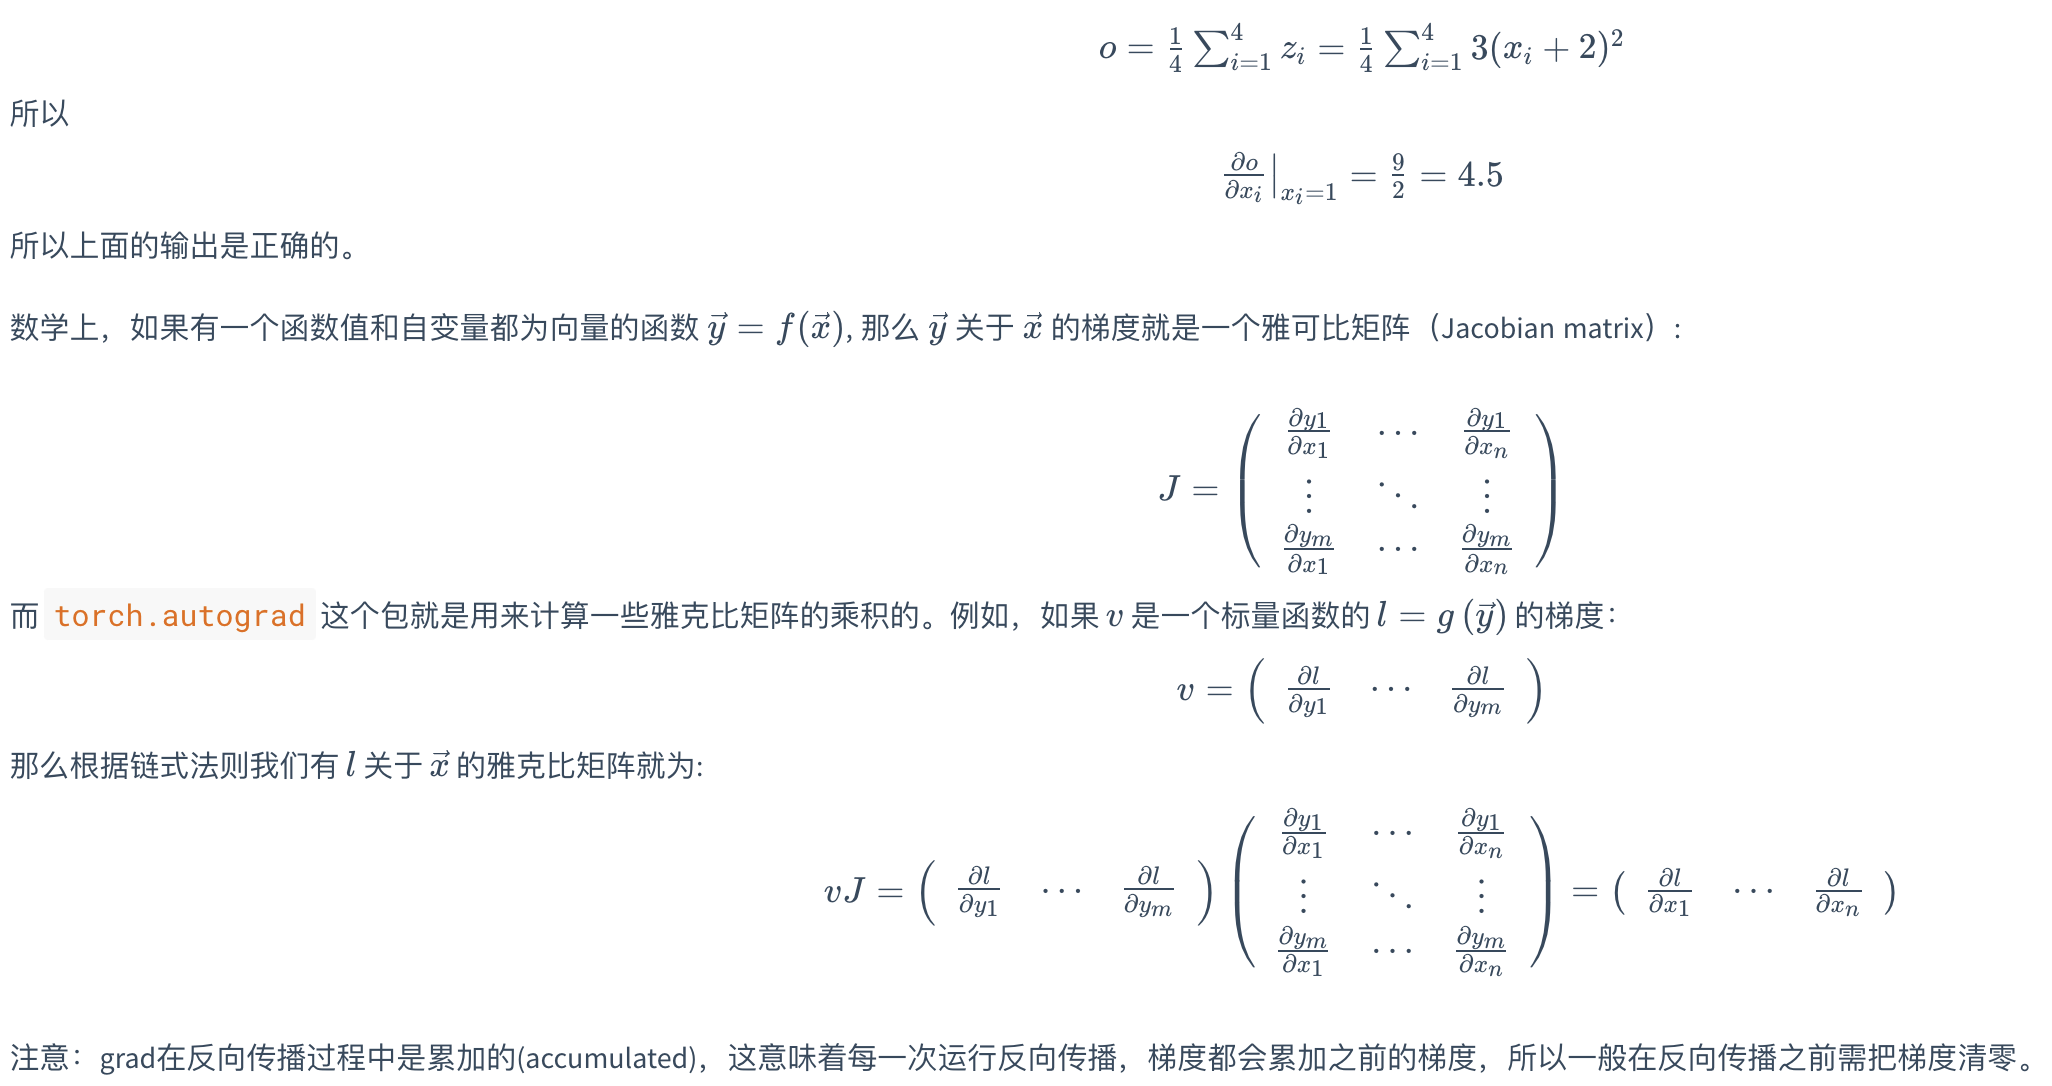

In [45]:
out2 = x.sum()

out2.backward()
print(x.grad)

out3 = x.sum()
x.grad.data.zero_()
out3.backward()
print(x.grad)

tensor([[2., 2.],
        [2., 2.]])
tensor([[1., 1.],
        [1., 1.]])


###### 为什么在y.backward()时，如果y是标量，则不需要为backward()传入任何参数；否则，需要传入一个与y同形的Tensor? 简单来说就是为了避免向量（甚至更高维张量）对张量求导，而转换成标量对张量求导。举个例子，假设形状为 m x n 的矩阵 X 经过运算得到了 p x q 的矩阵 Y，Y 又经过运算得到了 s x t 的矩阵 Z。那么按照前面讲的规则，dZ/dY 应该是一个 s x t x p x q 四维张量，dY/dX 是一个 p x q x m x n的四维张量。问题来了，怎样反向传播？怎样将两个四维张量相乘？？？这要怎么乘？？？就算能解决两个四维张量怎么乘的问题，四维和三维的张量又怎么乘？导数的导数又怎么求，这一连串的问题，感觉要疯掉…… 为了避免这个问题，我们不允许张量对张量求导，只允许标量对张量求导，求导结果是和自变量同形的张量。所以必要时我们要把张量通过将所有张量的元素加权求和的方式转换为标量，举个例子，假设y由自变量x计算而来，w是和y同形的张量，则y.backward(w)的含义是：先计算 l = torch.sum(y * w)，则l是个标量，然后求l对自变量x的导数。 参考

In [46]:
x = torch.tensor([1.0, 2.0, 3.0, 4.0], requires_grad=True)
y = 2 * x
z = y.view(2, 2)
print(z)
'''
现在 z 不是一个标量，所以在调用backward时需要传入一个和z同形的权重向量进行加权求和得到一个标量。
'''

v = torch.tensor([[1.0, 0.1], [0.01, 0.001]], dtype=torch.float)
z.backward(v)
print(x.grad)
#注意，x.grad是和x同形的张量。


tensor([[2., 4.],
        [6., 8.]], grad_fn=<ViewBackward>)
tensor([2.0000, 0.2000, 0.0200, 0.0020])


In [47]:
# 中断梯度追踪的例子
x = torch.tensor(1.0, requires_grad=True)
y1 = x ** 2 
with torch.no_grad():
    y2 = x ** 3
y3 = y1 + y2

print(x.requires_grad)
print(y1, y1.requires_grad) # True
print(y2, y2.requires_grad) # False
print(y3, y3.requires_grad) # True

True
tensor(1., grad_fn=<PowBackward0>) True
tensor(1.) False
tensor(2., grad_fn=<AddBackward0>) True


In [50]:
y3.backward()
print(x.grad)

tensor(2.)


###### 此外，如果我们想要修改tensor的数值，但是又不希望被autograd记录（即不会影响反向传播），那么我么可以对tensor.data进行操作。

In [55]:
x = torch.ones(1,requires_grad=True)

print(x.data) # 还是一个tensor
print(x.data.requires_grad) # 但是已经是独立于计算图之外

y = 2 * x
x.data *= 100 # 只改变了值，不会记录在计算图，所以不会影响梯度传播

y.backward()
print(x) # 更改data的值也会影响tensor的值
print(x.grad)

tensor([1.])
False
tensor([1.], requires_grad=True)
tensor([2.])
